## 0. 학습 세팅

In [ ]:
!pip install torchmetrics
!pip install foolbox

### 1) 메모리 정리

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

### 2) 수정된 코드 자동 업데이트

In [ ]:
%load_ext autoreload
%autoreload 2
import foolbox as fb

## 1. Load library

In [ ]:
from google.colab import drive

# Mount goole drive
drive.mount('/content/drive')

# Move to the project directory

#======================구글 드라이브 경로 지정==================================
%cd /content/drive/MyDrive/RetinaProject_final/RetinaProject
#===============================================================================

Mounted at /content/drive
/content/drive/MyDrive/RetinaProject_final/RetinaProject
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 13.2 MB/s 


In [ ]:
import os
import time
import copy
"""
import json
import glob

import numpy as np
from PIL import Image

from torchmetrics.aggregation import MeanMetric
"""
import argparse
import easydict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
"""
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
"""
import torchvision.transforms as T

from torch.utils.tensorboard import SummaryWriter
"""
import torch.utils.data as data
"""
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.functional.classification import accuracy

from src.models import vgg11_config, vgg13_config, vgg16_config
from src.models import VGG, get_vgg_layers
from src.engines import train, evaluate, get_predictions
from src.engines import plot_most_correct_wrong, epoch_time, normalize_image
from src.utils import load_checkpoint, save_checkpoint, save_transform
import sys

sys.setrecursionlimit(10**7)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 2. Variable Declaration

In [ ]:
# # Jupyter 외 환경
# parser = argparse.ArgumentParser()
# parser.add_argument("--title", type=str, default="baseline")
# parser.add_argument("--device", type=str, default="cuda")
# parser.add_argument("--root", type=str, default="data")
# parser.add_argument("--batch_size", type=int, default=64)
# parser.add_argument("--num_workers", type=int, default=2)
# parser.add_argument("--epochs", type=int, default=100)
# parser.add_argument("--lr", type=float, default=0.001)
# parser.add_argument("--logs", type=str, default='logs')
# parser.add_argument("--checkpoints", type=str, default='checkpoints')
# parser.add_argument("--resume", type=bool, default=False)
# args = parser.parse_args()

# Jupyter 환경
args = easydict.EasyDict({
        "title" : "Retina_ML_7.5r1e-5_Aug3_NoiseStudent_GAN",
        #===============baseline 최고 성능 모델명==========================
        "load_model" : "Retina_ML_7.5r1e-5_Aug3",
        #==================================================================
        "device" : "cuda",
        "root" : "data",
        "batch_size" : 32, # !!!
        "num_workers" : 2,
        "epochs" : 100, # !!!
        "lr" : 7.5e-5, # !!!
        "logs" : "logs",
        "checkpoints" : "checkpoints",
        "transform_dir" : "transform_infor",
        "resume" : False,
        "train_ratio" : 0.8,
        "val_ratio" : 0.2,
        "test_ratio" : 1.0,
        "output_dim" : 2
    })

## 3. Image Data Preprocessing

### 1) 이미지 변환

In [ ]:
"""
# Load Dataset
class RetinaDataset(Dataset):
    # image dataset 전체 경로 저장 -> tranform
    def __init__(self, root, transform=None):
        super(RetinaDataset, self).__init__()
        self.make_dataset(root)
        self.transform = transform
    
    # image dataset 전체 경로 저장
    def make_dataset(self, root):
        # class(폴더명) 불러오기
        self.data = []
        categories = os.listdir(root)
        categories = sorted(categories)
        
        # class -> label 변환 + 각 class의 이미지 파일 전부 가져오기
        for label, category in enumerate(categories):
            images = glob.glob(f'{root}/{category}/*.png')
            for image in images:
                self.data.append((image, label))
    
    # data 개수
    def __len__(self):
        return len(self.data)
    
    # 경로에 있는, 지정한 idx의 이미지 읽기 -> RGB 변환 -> tranform -> image, label 반환
    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = self.read_image(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    # 경로에 있는 image 읽기 -> RGB 변환
    def read_image(self, path):
        image = Image.open(path)
        return image.convert('RGB')
"""

# Build dataset
"""
# train, val, test dataset load + make loader
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]) # transform을 train과 test 따로따로 설정해줘야하나?

dataset_root = "data/Retina"
dataset = RetinaDataset(dataset_root, transform)
train_size = int(dataset_size * args.train_ratio)
val_size = int(dataset_size * args.val_ratio)
test_size = dataset_size - train_size - val_size # random_split에서 dataset_size = train_size + val_size + test_size가 되지 않으면 오류 발생

print("[dataset load complete]") # 확인용 코드

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False, drop_last=False)

# 확인용 코드
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(val_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

print(f"train_dataset 개수 : {len(train_dataset)}, " + f"train_loader 개수 : {len(train_loader)}") # train_data 개수, train_loader batch set 개수
print(f"val_dataset 개수 : {len(val_dataset)}, " + f"val_loader 개수 : {len(val_loader)}") # val_data 개수, val_loader batch set 개수
print(f"test_dataset 개수 : {len(test_dataset)}, " + f"test_loader 개수 : {len(test_loader)}") # test_data 개수, test_loader batch set 개수

# Build model
model = ConvNet()
model = model.to(args.device)
"""
# 이미지 변환
train_transforms = T.Compose([
    T.Resize((256, 256)), # 이미지 크기 재조절
    T.RandomOrder([
        # T.RandomRotation(5), # 이미지 회전(5도 이하)
        # T.RandomHorizontalFlip(0.5), # 이미지 좌우 대칭(50% 확률)
#         T.RandomRotation(180),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomAutocontrast(),
#         T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
#         T.RandomAffine(180, shear=20),
#         T.RandomPerspective(fill=[255,255,255]),
#         T.RandomGrayscale(p=0.5),
#         T.RandomResizedCrop((256, 256)),
    ]),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
    T.Resize((256, 256)), 
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

#==================================================================================================
stu_transforms_GAN = T.Compose([
    T.Resize((256, 256)),
    T.RandomOrder([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
        T.RandomGrayscale(p=0.2),
        T.RandomInvert(p = 0.2),
        T.RandomPosterize(1),
        T.RandomEqualize(p = 0.5)
    ]),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
#==================================================================================================

# transform 정보 저장
save_transform(args.transform_dir, train_transforms, test_transforms, args.title)

### 2) 이미지 데이터셋 불러오기 + 이미지 변환

In [ ]:
#============================원본 망막 데이터 저장 경로========================================================
train_path = "/content/drive/MyDrive/RetinaProject_final/RetinaProject/data/Retina_Some_binary/train"
test_path = "/content/drive/MyDrive/RetinaProject_final/RetinaProject/data/Retina_Some_binary/test"
#==============================================================================================================

train_dataset = torchvision.datasets.ImageFolder(
    train_path, 
    transform = train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    test_path, 
    transform = test_transforms
)

print("len(train_dataset) : ", len(train_dataset))
print("len(test_dataset) : ", len(test_dataset))

#==================================================================================================

#===============================GAN 데이터 저장 경로=================================================
stu_path_GAN = "/content/drive/MyDrive/RetinaProject_final/RetinaProject/data/StudentData_GAN"
#====================================================================================================


stu_dataset1_GAN = torchvision.datasets.ImageFolder(
    stu_path_GAN, 
    transform = stu_transforms_GAN
)

stu_dataset2_GAN = torchvision.datasets.ImageFolder(
    stu_path_GAN, 
    transform = stu_transforms_GAN
)

stu_dataset3_GAN = torchvision.datasets.ImageFolder(
    stu_path_GAN, 
    transform = stu_transforms_GAN
)

stu_dataset_GAN = stu_dataset1_GAN + stu_dataset2_GAN + stu_dataset3_GAN

print("len(stu_dataset1) : ", len(stu_dataset1_GAN))
print("len(stu_dataset2) : ", len(stu_dataset2_GAN))
print("len(stu_dataset3) : ", len(stu_dataset3_GAN))
#==================================================================================================

len(train_dataset) :  4532
len(test_dataset) :  1132
len(stu_dataset1) :  2839
len(stu_dataset2) :  2839
len(stu_dataset3) :  2839


### 3) 훈련, 검증 데이터 분할 + 검증 이미지 재변환

In [ ]:
all_train_dataset_size = len(train_dataset)
train_dataset_size = int(all_train_dataset_size * args.train_ratio)
valid_dataset_size = all_train_dataset_size - train_dataset_size

splited_train_dataset, splited_valid_dataset = random_split(train_dataset, [train_dataset_size, valid_dataset_size]) # 훈련 데이터셋, 검증 데이터셋 크기 결정

In [ ]:
splited_valid_dataset = copy.deepcopy(splited_valid_dataset)
splited_valid_dataset.dataset.transform = test_transforms

### 4) 데이터 로드 to 메모리

## 4. Model Define

### 1) 모델 정의

In [ ]:
# Build model
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
model = VGG(vgg11_layers, args.output_dim)
model = model.to(args.device)

### +) 학생 모델 -> 선생 모델 이동

In [ ]:
#==================================================================================================

#===============================================baseline 최고 성능 모델 저장 경로=========================================================
model.load_state_dict(torch.load(f"/content/drive/MyDrive/RetinaProject_final/RetinaProject/best_valid_model/{args.load_model}.pt"))
#=========================================================================================================================================
model.eval()

train_dataset_stu_GAN = copy.deepcopy(train_dataset)
one = 0
zero = 0
for i in range(len(stu_dataset_GAN)):
    model.eval()
    ima = stu_dataset_GAN[i][0].unsqueeze(0)
    ima = ima.cuda()
    if model(ima)[0][0] >= 0.0:
        idx = [[1]]
        idx[0][0] = stu_dataset_GAN[i][0]
        idx[0].append(0)
        a = tuple(idx)
        train_dataset_stu_GAN = train_dataset_stu_GAN + a
        zero += 1
    elif model(ima)[0][0] <= 0.0:
        idx = [[1]]
        idx[0][0] = stu_dataset_GAN[i][0]
        idx[0].append(1)
        a = tuple(idx)
        train_dataset_stu_GAN = train_dataset_stu_GAN + a
        one+=1
#==================================================================================================

In [ ]:
print("zero :", zero)
print("one :", one)

zero : 6197
one : 2320


In [ ]:
print(len(train_dataset))
print(len(train_dataset_stu_GAN))

4532
13049


In [ ]:
all_train_dataset_size_stu_GAN = len(train_dataset_stu_GAN)
train_dataset_size_stu_GAN = int(all_train_dataset_size_stu_GAN * args.train_ratio)
valid_dataset_size_stu_GAN = all_train_dataset_size_stu_GAN - train_dataset_size_stu_GAN

splited_train_dataset_stu_GAN, splited_valid_dataset_stu_GAN = random_split(train_dataset_stu_GAN, [train_dataset_size_stu_GAN, valid_dataset_size_stu_GAN]) # 훈련 데이터셋, 검증 데이터셋 크기 결정

In [ ]:
print(len(splited_train_dataset_stu_GAN))
print(len(splited_valid_dataset_stu_GAN))

10439
2610


In [ ]:
splited_valid_dataset_stu_GAN.dataset.transform = test_transforms

In [ ]:
train_loader_stu_GAN = DataLoader(splited_train_dataset_stu_GAN,
                            shuffle = True,
                            batch_size = args.batch_size, 
                            num_workers=args.num_workers
                        )
val_loader_stu_GAN = DataLoader(splited_valid_dataset_stu_GAN,
                            batch_size = args.batch_size,
                            num_workers=args.num_workers
                        )
test_loader = DataLoader(test_dataset,
                            batch_size = args.batch_size,
                            num_workers=args.num_workers
                        )

print(f"train_dataset 개수 : {len(splited_train_dataset_stu_GAN)}, " + f"train_loader 개수 : {len(train_loader_stu_GAN)}") # train_data 개수, train_loader batch set 개수
print(f"val_dataset 개수 : {len(splited_valid_dataset_stu_GAN)}, " + f"val_loader 개수 : {len(val_loader_stu_GAN)}") # val_data 개수, val_loader batch set 개수
print(f"test_dataset 개수 : {len(test_dataset)}, " + f"test_loader 개수 : {len(test_loader)}") # test_data 개수, test_loader batch set 개수

train_dataset 개수 : 10439, train_loader 개수 : 327
val_dataset 개수 : 2610, val_loader 개수 : 82
test_dataset 개수 : 1132, test_loader 개수 : 36


### 2) 옵티마이저 + 손실함수 + 스케쥴러 + 메트릭 함수 정의

In [ ]:
# Build optimizer 
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# Build scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs * len(train_loader_stu_GAN))

# Build loss function
loss_fn = nn.CrossEntropyLoss()

# Build metric function
"""
# 정확도 측정 함수
def calculate_accuracy(y_pred, y): # ???
    top_pred = y_pred.argmax(1, keepdim = True)
    # print("top_pred : ", top_pred)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    # print("correct : ", correct)
    acc = correct.float() / y.shape[0]
    # print("acc : ", acc)
    return acc
"""
metric_fn = accuracy

### 3) logger 정의

In [ ]:
# Build logger
train_logger = SummaryWriter(f'{args.logs}/train/{args.title}')
val_logger = SummaryWriter(f'{args.logs}/val/{args.title}')
test_logger = SummaryWriter(f'{args.logs}/test/{args.title}')

## 5. Model Train

### 1) Load model epoch

In [ ]:
# Load model
start_epoch = 0
if args.resume:
    start_epoch = load_checkpoint(args.checkpoints, args.title, model, optimizer)

### 2) Train model

In [ ]:
best_valid_loss = float('inf')
for epoch in range(start_epoch, args.epochs):
    """
    # start timer
    start_time = time.time() # 확인용 코드
    """
    # 모델 학습 소요시간
    start_time = time.monotonic()

    # train one epoch + evaluate one epoch
    train_summary = train(train_loader_stu_GAN, model, optimizer, scheduler, loss_fn, metric_fn, args.device)
    val_summary = evaluate(val_loader_stu_GAN, model, loss_fn, metric_fn, args.device)

    # write log
    train_logger.add_scalar('Loss', train_summary['loss'], epoch + 1)
    train_logger.add_scalar('Accuracy', train_summary['metric'], epoch + 1)
    val_logger.add_scalar('Loss', val_summary['loss'], epoch + 1)
    val_logger.add_scalar('Accuracy', val_summary['metric'], epoch + 1)

    # 최적 loss인 model 저장
    if val_summary['loss'] < best_valid_loss:
        best_valid_loss = val_summary['loss']
        #================================================학습된 모델 저장 경로===================================================================
        torch.save(model.state_dict(), f"/content/drive/MyDrive/RetinaProject_final/RetinaProject/NoiseStudent_GAN_model/{args.title}.pt")
        #========================================================================================================================================
        
    # save model
    save_checkpoint(args.checkpoints, args.title, model, optimizer, epoch + 1)

    # 모델 학습 소요시간
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print log
    """
    print((
        f'[Epoch {epoch+1}] '
        + f'{epoch + 1}epoch time {end_time - start_time:.02f}, '
        + f'Train Loss {train_summary["loss"]:.04f}, '
        + f'Train Accuracy {train_summary["metric"]:.04f}, '
        + f'Test Loss {val_summary["loss"]:.04f}, '
        + f'Test Accuracy {val_summary["metric"]:.04f}'
    ))
    """
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_summary["loss"]:.3f} | Train Acc: {train_summary["metric"]:.2f}%')
    print(f'\t Valid Loss: {val_summary["loss"]:.3f} | Valid Acc: {val_summary["metric"]:.2f}%')
    print(f'\t scheduled_lr : {scheduler.get_last_lr()[0]}')

Epoch: 01 | Epoch Time: 20m 18s
	 Train Loss: 0.621 | Train Acc: 0.69%
	 Valid Loss: 0.617 | Valid Acc: 0.67%
	 scheduled_lr : 7.498149601371493e-05
Epoch: 02 | Epoch Time: 2m 31s
	 Train Loss: 0.605 | Train Acc: 0.69%
	 Valid Loss: 0.599 | Valid Acc: 0.71%
	 scheduled_lr : 7.492600231606014e-05
Epoch: 03 | Epoch Time: 2m 31s
	 Train Loss: 0.606 | Train Acc: 0.70%
	 Valid Loss: 0.595 | Valid Acc: 0.71%
	 scheduled_lr : 7.483357367261558e-05
Epoch: 04 | Epoch Time: 2m 28s
	 Train Loss: 0.598 | Train Acc: 0.70%
	 Valid Loss: 0.599 | Valid Acc: 0.70%
	 scheduled_lr : 7.470430129929291e-05
Epoch: 05 | Epoch Time: 2m 27s
	 Train Loss: 0.596 | Train Acc: 0.70%
	 Valid Loss: 0.605 | Valid Acc: 0.69%
	 scheduled_lr : 7.453831277231765e-05
Epoch: 06 | Epoch Time: 2m 31s
	 Train Loss: 0.593 | Train Acc: 0.70%
	 Valid Loss: 0.594 | Valid Acc: 0.71%
	 scheduled_lr : 7.433577190232583e-05
Epoch: 07 | Epoch Time: 2m 28s
	 Train Loss: 0.588 | Train Acc: 0.71%
	 Valid Loss: 0.599 | Valid Acc: 0.70%
	 

## 6. Model Test

In [ ]:
# 학습된 모델 불러오기

#==============================================학습된 모델 저장 경로========================================================================
model.load_state_dict(torch.load(f"/content/drive/MyDrive/RetinaProject_final/RetinaProject/NoiseStudent_GAN_model/{args.title}.pt"))
#===========================================================================================================================================


# 모델 성능 측정
test_summary = evaluate(test_loader, model, loss_fn, metric_fn, args.device)

# write log
test_logger.add_scalar('Loss', test_summary['loss'], epoch + 1)
test_logger.add_scalar('Accuracy', test_summary['metric'], epoch + 1)

print(f'Test Loss: {test_summary["loss"]:.3f} | Test Acc: {test_summary["metric"]:.2f}%')

Test Loss: 0.526 | Test Acc: 0.78%


### 1) 예측한 값 추출 + 맞춘 이미지 정보 추출 + 틀린 이미지 정보 추출

In [ ]:
correct_examples, wrong_examples = get_predictions(test_loader, model, args.device)

In [ ]:
for correct_example in correct_examples: # 확인용 코드
    print("correct_example : ", correct_example[2])
for wrong_example in wrong_examples: # 확인용 코드
    print("wrong_example : ", wrong_example[2])

correct_example :  tensor([0.9919, 0.0081])
correct_example :  tensor([0.9891, 0.0109])
correct_example :  tensor([0.9886, 0.0114])
correct_example :  tensor([0.9836, 0.0164])
correct_example :  tensor([0.9820, 0.0180])
correct_example :  tensor([0.9816, 0.0184])
correct_example :  tensor([0.9791, 0.0209])
correct_example :  tensor([0.9759, 0.0241])
correct_example :  tensor([0.9728, 0.0272])
correct_example :  tensor([0.9709, 0.0291])
correct_example :  tensor([0.9694, 0.0306])
correct_example :  tensor([0.9673, 0.0327])
correct_example :  tensor([0.9670, 0.0330])
correct_example :  tensor([0.9670, 0.0330])
correct_example :  tensor([0.9636, 0.0364])
correct_example :  tensor([0.9619, 0.0381])
correct_example :  tensor([0.9606, 0.0394])
correct_example :  tensor([0.9582, 0.0418])
correct_example :  tensor([0.9573, 0.0427])
correct_example :  tensor([0.9560, 0.0440])
correct_example :  tensor([0.9549, 0.0451])
correct_example :  tensor([0.9531, 0.0469])
correct_example :  tensor([0.951

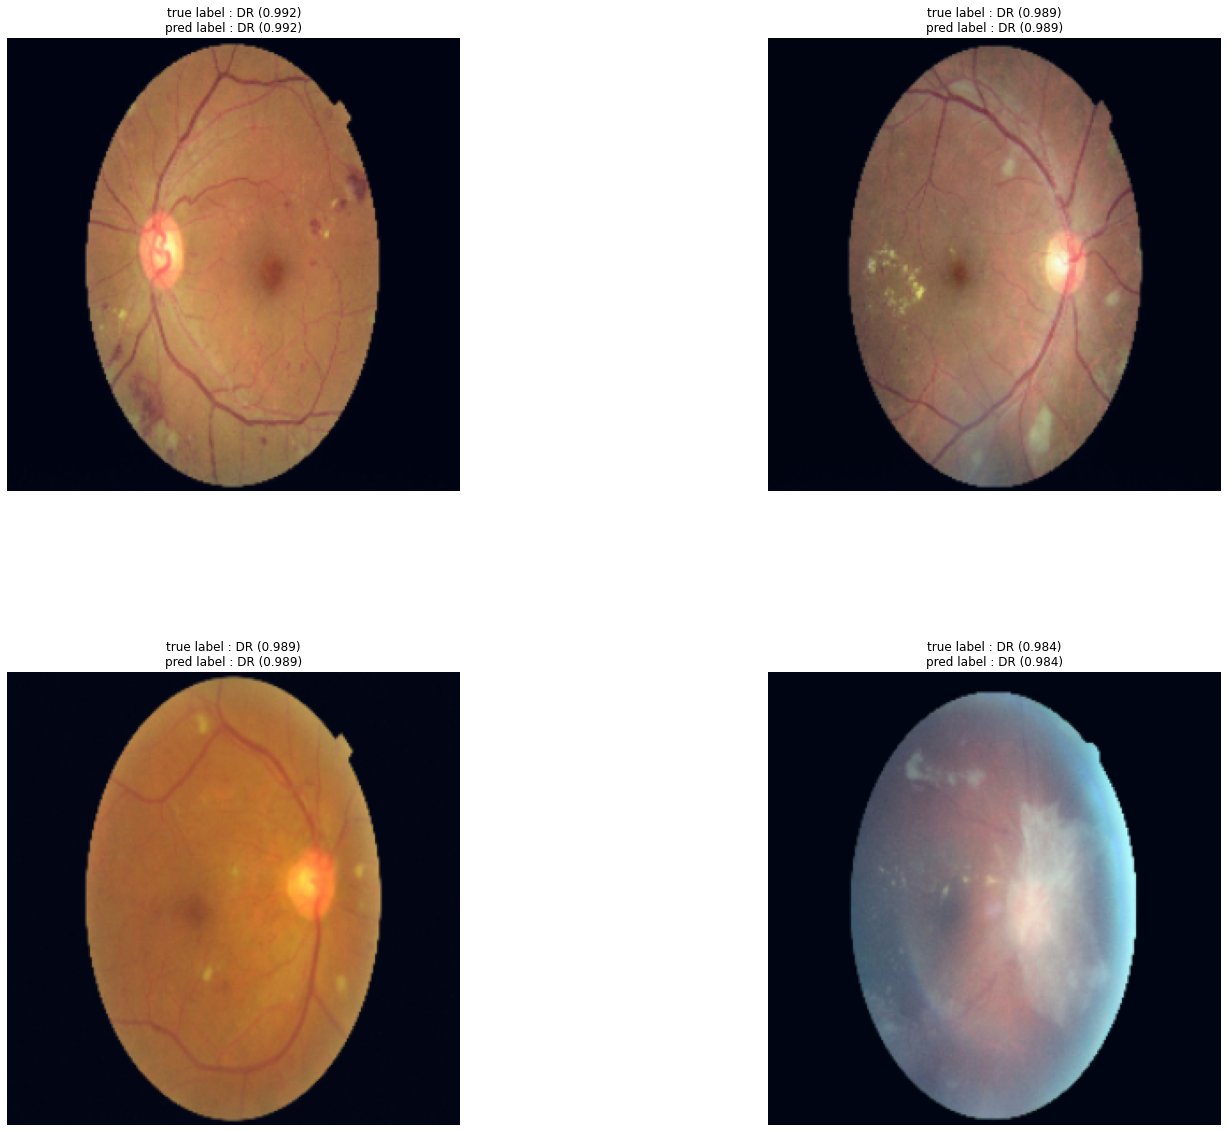

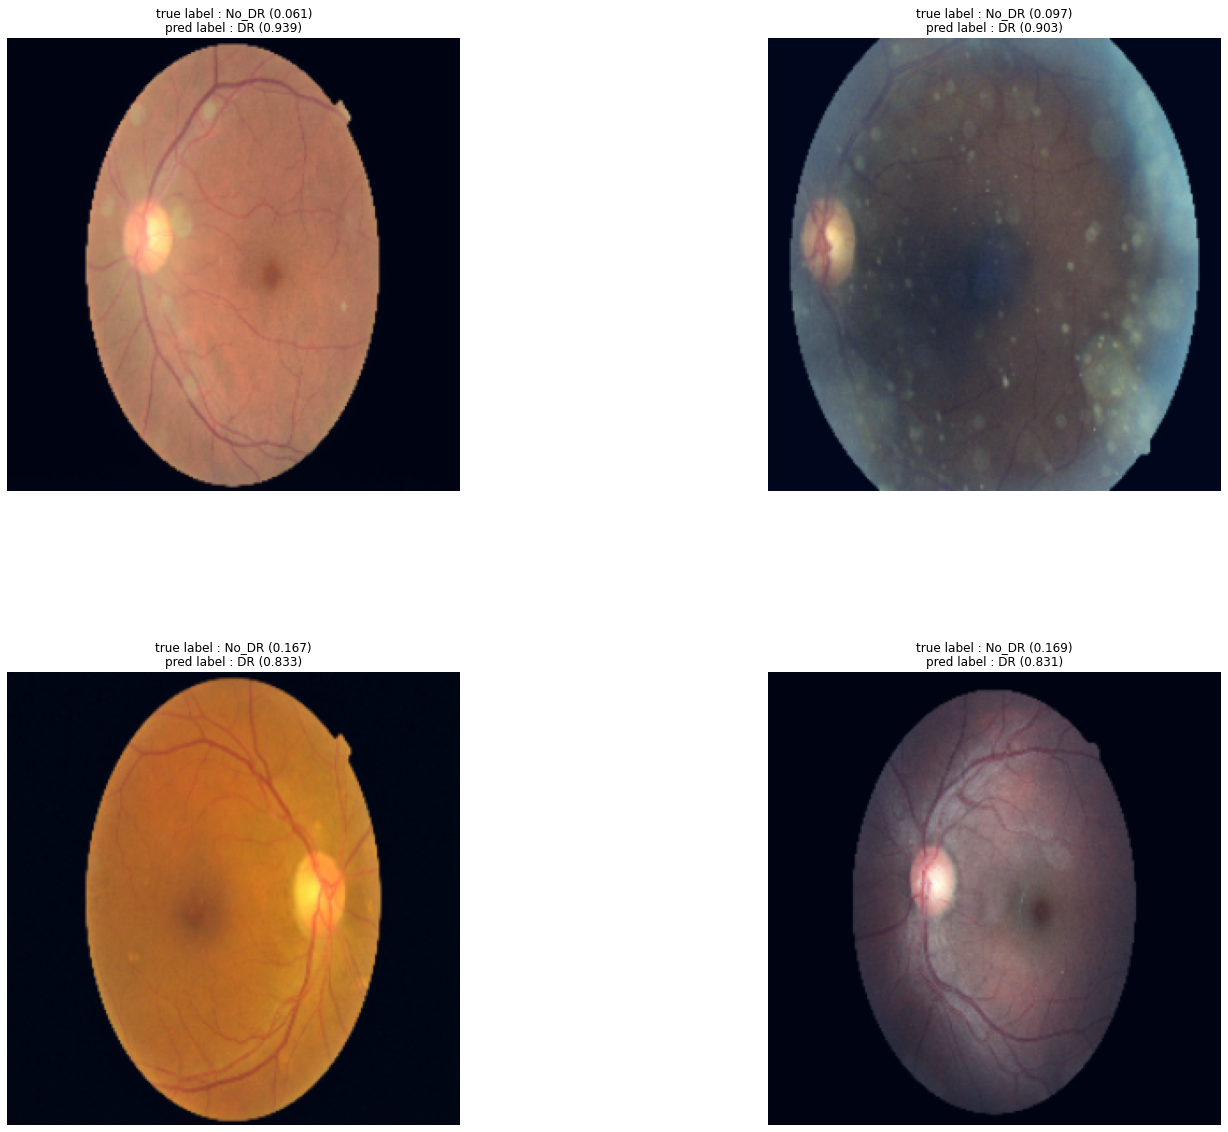

In [ ]:
classes = test_dataset.classes
n_images = 5
plot_most_correct_wrong(correct_examples, wrong_examples, classes, n_images)